In [2]:
%pip install -U langchain_community langchain_anthropic langchain_experimental matplotlib langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 131.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.3/289.3 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      S

In [1]:
pip install langgraph

**Define Tools**

We will define some tools that our agents will use in the future

In [7]:
!pip install dnspython scanless


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 5.2 MB/s eta 0:00:00


In [15]:
from typing import Annotated
from langchain_core.tools import tool
import scanless
import json
import dns.resolver


@tool
def get_dns_record(target: str):
    """Returns the A record (IPv4 address) for a given domain name."""
    result = dns.resolver.resolve(target, "A")
    for ipval in result:
        ip_address = ipval.to_text()
    return ip_address


@tool
def scan_open_ports(target_ip: str):
    """Performs a remote port scan using scanless and returns the results."""
    s1 = scanless.Scanless()
    service = "ipfingerprints"
    output = s1.scan(target_ip, scanner=service)
    json_output = json.dumps(output, indent=2)
    return json_output


TOOLS = [scan_open_ports, get_dns_record]


**Create graph**

After defining the tools with some helper functions, lets create the individual agents below and tell them how to talk to each other using langGraph

**Define Agent Nodes**

Lets, create a system prompt for each agent

In [13]:
pip install langchain_groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 4.3 MB/s eta 0:00:00


In [11]:

def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant specializing in Cyber security, collaborating with other security assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )


In [ ]:
from typing import Literal
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_groq import ChatGroq
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command


llm = ChatGroq(model="llama-3.3-70b-versatile", api_key="Enter API", temperature=0)

#this block determines if the agent delegated the task has solved the question or we should go to the other
def get_next_node(last_message:BaseMessage, goto:str):
  if "FINAL ANSWER" in last_message.content:
    return END
  return goto

#lets create a Research agent and node
resolver_agent=create_react_agent(
    llm,
    tools=[get_dns_record],
    prompt=make_system_prompt(
        "You can only resolve domain names to there respective IP addresses. You are working with an o_ports colleague"
    )
)

def resolver_node(state: MessagesState,)-> Command[Literal["ports", END]]:
  result=resolver_agent.invoke(state)
  goto=get_next_node(result["messages"][-1], "ports")

  result["messages"][-1]=HumanMessage(
      content=result["messages"][-1].content, name="resolver"
  )

  return Command(
      update={
          #share internal message history of research agent with other agents
          "messages":result["messages"]
      },
      goto=goto
  )


#create the open port scaning agent
ports_agent=create_react_agent(
    llm,
    tools=[scan_open_ports],
    prompt=make_system_prompt(
        "You can scan open ports. You are working with a DNS resolver colleague"
    )
)

def ports_node(state:MessagesState)-> Command[Literal["resolver", END]]:
  result=ports_agent.invoke(state)
  goto=get_next_node(result["messages"][-1],"resolver")

  result["messages"[-1]]=HumanMessage(
      content=result["messages"][-1].content, name="ports"
  )

  return Command(
      update={
          #share internal message history with other agents
          "messages":result["messages"],
      },
      goto=goto,
  )



**Define the Graph**

Lets put it all together

In [21]:
from langgraph.graph import StateGraph, START

workflow=StateGraph(MessagesState)
workflow.add_node("resolver", resolver_node)
workflow.add_node("ports", ports_node)

workflow.add_edge(START, "resolver")
graph=workflow.compile()


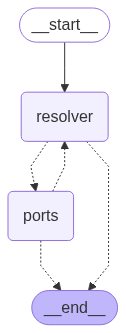

In [22]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [23]:
#lets pass in our quetion
messages=[HumanMessage(content="What is the ip of jkuat.ac.ke")]
print(f"Human Quize: {messages}")
messages=graph.invoke({"messages":messages})

#display
for m in messages['messages']:
    m.pretty_print()


Human Quize: [HumanMessage(content='What is the ip of jkuat.ac.ke', additional_kwargs={}, response_metadata={})]


================================ Human Message =================================

What is the ip of jkuat.ac.ke
================================== Ai Message ==================================
Tool Calls:
  get_dns_record (8nx4xb1x9)
 Call ID: 8nx4xb1x9
  Args:
    target: jkuat.ac.ke
================================= Tool Message =================================
Name: get_dns_record

197.136.12.5
================================ Human Message =================================
Name: resolver

The IP address for jkuat.ac.ke is 197.136.12.5
================================== Ai Message ==================================
Tool Calls:
  scan_open_ports (khqy443pb)
 Call ID: khqy443pb
  Args:
    target_ip: 197.136.12.5
================================= Tool Message =================================
Name: scan_open_ports

{
  "raw": "Host is up (0.15s latency).\nNot shown: 491 filtered ports\nPORT    STATE SERVICE\n80/tcp  open  http\n443/tcp open  https\nAggressive OS guesses: Linux 2.6.32